# BANK CUSTOMER SEGMENTATION USING K-MODES CLUSTERING

by: Indah Yunita

---
Note (by myself):

Saya mengasumsikan bank yang dianalisis adalah bank syariah yang benar-benar menerapkan prinsip syariah dalam muamalah sehingga segala rekomendasi bisnis dan analisis disini dilakukan dengan penyesuaian akad sesuai syariah.




# Challenge

- Do the same exact clustering process until you can get customer segmentation and the insight of each cluster towards a similar dataset: [`bank-full.csv`](https://raw.githubusercontent.com/binggas/public-dataset/main/bank%2Bmarketing/bank/bank-full.csv).

- Use this combination to determine each customer:
  1. `age`
  2. `job`
  3. `marital`
  4. `education`
  5. `default`
  6. `housing`
  7. `loan`
  8. `balance`

- What can you learn about the customer profile?

- Find the clusters from the data.

- Conclude the customer profile for each cluster.

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# Install kmodes if you have not yet
!pip install kmodes

# Import kmodes
from kmodes.kmodes import KModes

# Dataset

In [ ]:
df_bank_full = pd.read_csv("https://raw.githubusercontent.com/binggas/public-dataset/main/bank%2Bmarketing/bank/bank-full.csv", sep = ";")
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Feature Needed

In [ ]:
df_bank_full = df_bank_full[["age", "job", "marital", "education", "default", "housing", "loan", "balance"]]
df_bank_full.head()

,age,job,marital,education,default,housing,loan,balance
0,58,management,married,tertiary,no,yes,no,2143
1,44,technician,single,secondary,no,yes,no,29
2,33,entrepreneur,married,secondary,no,yes,yes,2
3,47,blue-collar,married,unknown,no,yes,no,1506
4,33,unknown,single,unknown,no,no,no,1


In [ ]:
print("columns: ", df_bank_full.shape[1])
print("rows: ", df_bank_full.shape[0])

columns:  8
rows:  45211


# Duplicated Data

In [ ]:
df_bank_full.duplicated().sum()

4163

- Because our main goal is to segment each customer, unlike the campaign segmentation we did in the notebook before this, we want to get distinct customer by the combination of `age`, `job`, `marital`, `education`, `default`, `housing`, and `loan`.


In [ ]:
df_bank_full.drop_duplicates(inplace=True)

In [ ]:
df_bank_full.isna().sum()

age          0
job          0
marital      0
education    0
default      0
housing      0
loan         0
balance      0
dtype: int64

# Change Data Type

To doing segmentation with K-Mode clustering we need to make sure that our data has numerical coloumns (int/float) or categorical column that have categoric type

In [ ]:
df_bank_full.dtypes

age           int64
job          object
marital      object
education    object
default      object
housing      object
loan         object
balance       int64
dtype: object

we need to change object data type to category type

In [ ]:
#categorical col
cat_col = ['job', 'marital', 'education', 'default', 'housing', 'loan']

#convert to category type
for cat in cat_col:
  df_bank_full[cat] = df_bank_full[cat].astype('category')

#check data type
df_bank_full.dtypes

age             int64
job          category
marital      category
education    category
default      category
housing      category
loan         category
balance         int64
dtype: object

Check unique value in each categorical columns

In [ ]:
for cat in cat_col:
  print(f'{cat}: ')
  print(df_bank_full[cat].unique())
  print('\n')


job: 
['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student',
                          'technician', 'unemployed', 'unknown']


marital: 
['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']


education: 
['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary', 'secondary', 'tertiary', 'unknown']


default: 
['no', 'yes']
Categories (2, object): ['no', 'yes']


housing: 
['yes', 'no']
Categories (2, object): ['no', 'yes']


loan: 
['no', 'yes']
Categories (2, object): ['no', 'yes']




# Data Distribution

Numeric value need to convert into categorical value, so we need to know the interval of numerical value

## Age Distribution

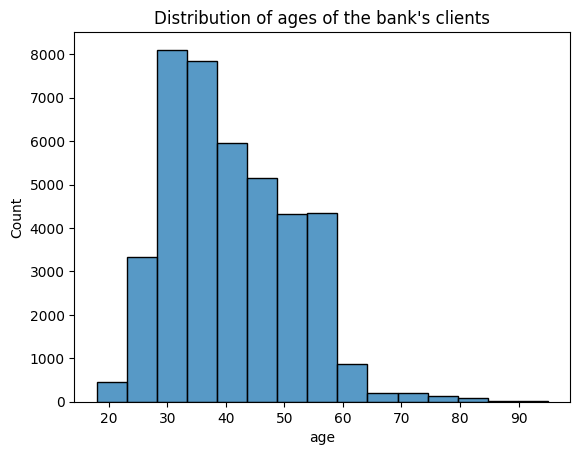

In [ ]:
# Draw plot
sns.histplot(data=df_bank_full,
             x='age',
             bins=15
             )

# Add title
plt.title("Distribution of ages of the bank's clients")

# Add label
plt.ylabel('Count')

# Show the plot
plt.show()



*   Age interval is between 10 and 90 <age< 100
*   Most client are 30-40 years old





## Balance Distribution

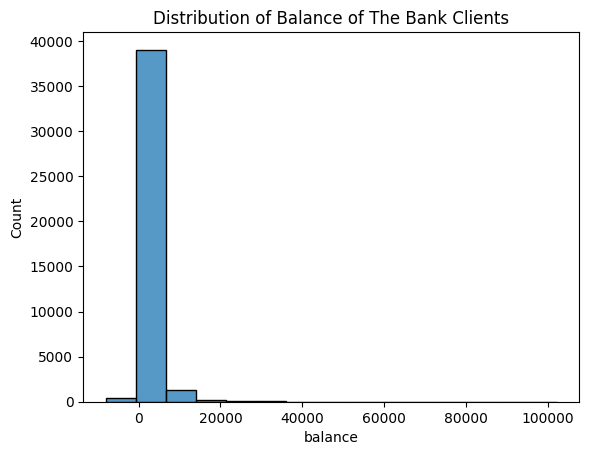

In [ ]:
#draw plot
sns.histplot(
    data = df_bank_full,
    x= 'balance',
    bins = 15,
    # log_scale=(False, True)
)

#add title
plt.title("Distribution of Balance of The Bank Clients")

#add label
plt.ylabel('Count')

#show plot
plt.show()

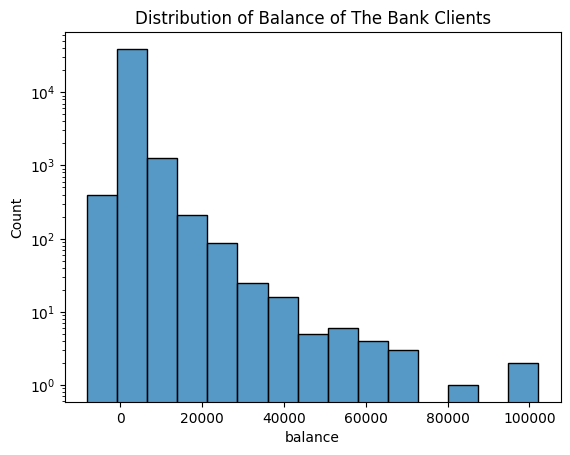

In [ ]:
#draw plot
sns.histplot(
    data = df_bank_full,
    x= 'balance',
    bins = 15,
    log_scale=(False, True)
)

#add title
plt.title("Distribution of Balance of The Bank Clients")

#add label
plt.ylabel('Count')

#show plot
plt.show()


*   Any negative data
*   data distribution is variative and most of them have balance = 0-20000

# Data Transformation

## Convert age and balance to bin (categorical)


---


Before doing this we must prepare a copy of the Dataframe that is specific to the clustering process and keep the previous Dataframe

In [ ]:
df_kmodes = df_bank_full.copy()
df_kmodes

,age,job,marital,education,default,housing,loan,balance
0,58,management,married,tertiary,no,yes,no,2143
1,44,technician,single,secondary,no,yes,no,29
2,33,entrepreneur,married,secondary,no,yes,yes,2
3,47,blue-collar,married,unknown,no,yes,no,1506
4,33,unknown,single,unknown,no,no,no,1
...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,no,yes,505
45206,51,technician,married,tertiary,no,no,no,825
45207,71,retired,divorced,primary,no,no,no,1729
45209,57,blue-collar,married,secondary,no,no,no,668


## Bin age and balance


In [ ]:
# Bin `age` column into 10 bins from 10 to 100, change type into category
df_kmodes['age_binned'] = pd.cut(df_kmodes['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype('category')

# bin balance
bin_edges = [-float('inf'), 0, 20000, 40000, 60000,80000, 100000, float('inf')] #inf menyatakan nilai tak hingga
bin_labels = ['Negative', '0-20000', '20000-40000', '40000-60000', '60000-80000', '80000-100000', 'above 100000']
df_kmodes['balance_binned'] = pd.cut(df_kmodes['balance'], bins= bin_edges, labels= bin_labels)


# Drop `age` column
df_kmodes.drop(['age', 'balance'], axis=1, inplace=True)

# Show first 5 rows
df_kmodes.head()

,job,marital,education,default,housing,loan,age_binned,balance_binned
0,management,married,tertiary,no,yes,no,"(50, 60]",0-20000
1,technician,single,secondary,no,yes,no,"(40, 50]",0-20000
2,entrepreneur,married,secondary,no,yes,yes,"(30, 40]",0-20000
3,blue-collar,married,unknown,no,yes,no,"(40, 50]",0-20000
4,unknown,single,unknown,no,no,no,"(30, 40]",0-20000


## Default, Housing, and Loan Transformation

default, housing, and loan just has 2 values (yes/no). So we must convert yes into 1 and no into 0

In [ ]:
df_kmodes['default'] = df_kmodes['default'].replace({'yes':1, 'no':0})
df_kmodes['housing'] = df_kmodes['housing'].replace({'yes': 1, 'no':0})
df_kmodes['loan'] = df_kmodes['loan'].replace({'yes':1, 'no': 0})
df_kmodes

,job,marital,education,default,housing,loan,age_binned,balance_binned
0,management,married,tertiary,0,1,0,"(50, 60]",0-20000
1,technician,single,secondary,0,1,0,"(40, 50]",0-20000
2,entrepreneur,married,secondary,0,1,1,"(30, 40]",0-20000
3,blue-collar,married,unknown,0,1,0,"(40, 50]",0-20000
4,unknown,single,unknown,0,0,0,"(30, 40]",0-20000
...,...,...,...,...,...,...,...,...
45205,technician,single,secondary,0,0,1,"(20, 30]",0-20000
45206,technician,married,tertiary,0,0,0,"(50, 60]",0-20000
45207,retired,divorced,primary,0,0,0,"(70, 80]",0-20000
45209,blue-collar,married,secondary,0,0,0,"(50, 60]",0-20000


## One hot encoding columns job, marital, and education

pisahkan kolom yang ingin di get dumies

In [ ]:
df_encoding = df_kmodes[['job', 'marital', 'education','age_binned', 'balance_binned']]
df_encoding

,job,marital,education,age_binned,balance_binned
0,management,married,tertiary,"(50, 60]",0-20000
1,technician,single,secondary,"(40, 50]",0-20000
2,entrepreneur,married,secondary,"(30, 40]",0-20000
3,blue-collar,married,unknown,"(40, 50]",0-20000
4,unknown,single,unknown,"(30, 40]",0-20000
...,...,...,...,...,...
45205,technician,single,secondary,"(20, 30]",0-20000
45206,technician,married,tertiary,"(50, 60]",0-20000
45207,retired,divorced,primary,"(70, 80]",0-20000
45209,blue-collar,married,secondary,"(50, 60]",0-20000


 One Hot Encoding

In [ ]:
df_encoding= pd.get_dummies(df_encoding)
df_encoding

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,"age_binned_(70, 80]","age_binned_(80, 90]","age_binned_(90, 100]",balance_binned_Negative,balance_binned_0-20000,balance_binned_20000-40000,balance_binned_40000-60000,balance_binned_60000-80000,balance_binned_80000-100000,balance_binned_above 100000
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
45206,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
45207,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
45209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Merge Table

In [ ]:
df_kmodes = pd.concat([df_encoding, df_kmodes[['default', 'housing', 'loan']]], axis= 1)
df_kmodes

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,balance_binned_Negative,balance_binned_0-20000,balance_binned_20000-40000,balance_binned_40000-60000,balance_binned_60000-80000,balance_binned_80000-100000,balance_binned_above 100000,default,housing,loan
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
45206,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
45207,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
45209,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
df_kmodes.shape

(41048, 38)

# Clustering

## Get The best number of cluster

In [ ]:
n_clusters = list(range(2, 6))
costs = []

for n in n_clusters:
    kmodes = KModes(n_clusters=n, init='random', n_init=10, max_iter=100, random_state=42)
    kmodes.fit(df_kmodes)
    cost = kmodes.cost_
    costs.append(cost)

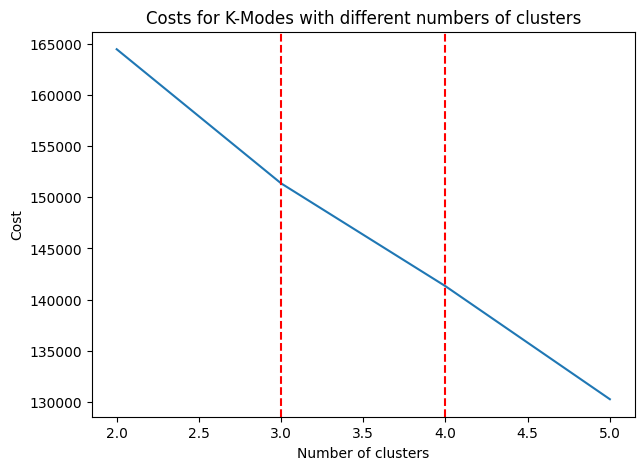

In [ ]:
# Plotting the cost:

plt.figure(figsize=(7,5))
plt.plot(n_clusters, costs)
plt.axvline(3, linestyle='--', c='r')
plt.axvline(4, linestyle='--', c='r')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Costs for K-Modes with different numbers of clusters')
plt.show()

based on cost, the number of cluster that we gonna use is 4

# Fit Clustering Algorithm to Data

In [ ]:
kmodes = KModes(n_clusters=4, init='random', n_init=10, max_iter=100, random_state=42)
df_bank_full['cluster_k-modes'] = kmodes.fit_predict(df_kmodes)
df_bank_full

,age,job,marital,education,default,housing,loan,balance,cluster_k-modes
0,58,management,married,tertiary,no,yes,no,2143,3
1,44,technician,single,secondary,no,yes,no,29,1
2,33,entrepreneur,married,secondary,no,yes,yes,2,0
3,47,blue-collar,married,unknown,no,yes,no,1506,1
4,33,unknown,single,unknown,no,no,no,1,0
...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,no,yes,505,2
45206,51,technician,married,tertiary,no,no,no,825,3
45207,71,retired,divorced,primary,no,no,no,1729,3
45209,57,blue-collar,married,secondary,no,no,no,668,3


# Analysis

## Age by Cluster

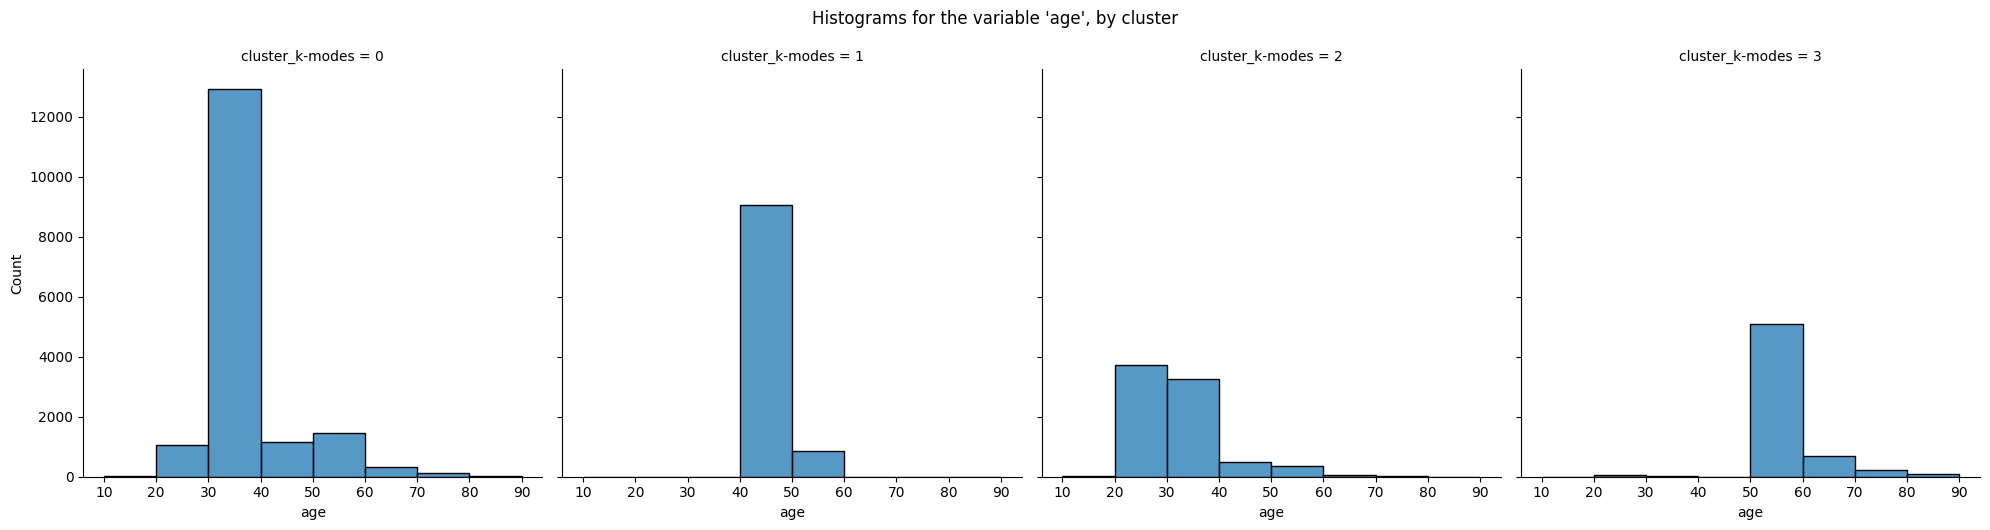

In [ ]:
diagram = sns.displot(data=df_bank_full,
                x='age',
                col='cluster_k-modes',
                bins=[10, 20, 30, 40, 50, 60, 70, 80, 90]
                )

diagram.fig.suptitle("Histograms for the variable 'age', by cluster", y=1.05)

plt.show()



*   Cluster 0 didominasi usia 30-40 tahun, namun masih ada usia muda antara 10-30 tahun di cluster ini dan usia tua 40-70 tahun kemudian ada sebagian kecil antara 70-90 tahun
*   Cluster 1 didominasi usia 40-50 tahun dan ada sebagian kecil usia 50-60 tahun
*   cluster 2 didominasi usia 20-40 tahun, sebagian kecil usia 40-80 tahun
*   cluster 3 didominasi usia 50-60 tahun





## Balance by Cluster

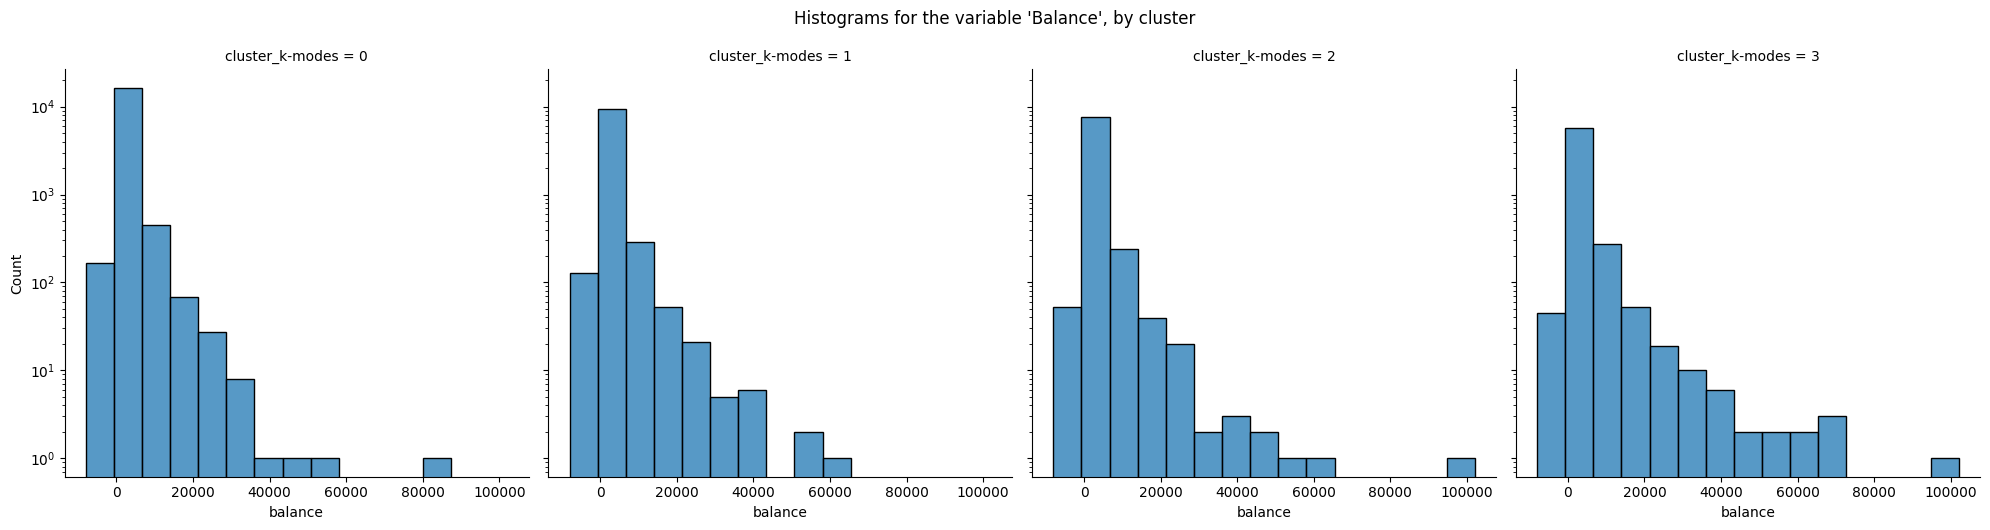

In [ ]:
diagram = sns.displot(data=df_bank_full,
                x='balance',
                col='cluster_k-modes',
                bins= 15,
                log_scale=(False, True),
                # multiple="dodge",
                # stat='density',
                # shrink=0.8,
                # common_norm=False
                )

diagram.fig.suptitle("Histograms for the variable 'Balance', by cluster", y=1.05)

plt.show()

Setiap cluster ada balance yang negative. Paling tinggi yang negative ada di cluster 0

## Average balance and age in each cluster

In [ ]:
selected_features = ['balance', 'age']
cluster_means = df_bank_full.groupby('cluster_k-modes')[selected_features].mean()
cluster_means

,balance,age
cluster_k-modes,,
0,1197.141168,37.075910
1,1371.542817,45.278839
2,1371.794296,31.710374
3,1885.283716,56.466406


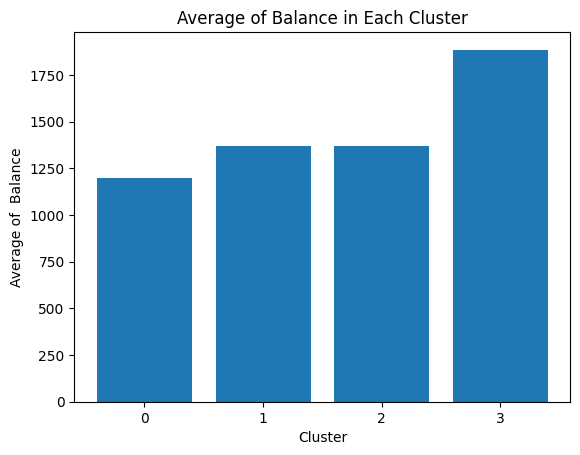

In [ ]:
plt.bar(cluster_means.index, cluster_means["balance"])
plt.xlabel('Cluster')
plt.ylabel('Average of  Balance')
plt.title('Average of Balance in Each Cluster')
plt.xticks(cluster_means.index)
plt.show()

Cluster dengan nilai rata-rata balance tertinggi adalah cluster 3

## Job by Cluster

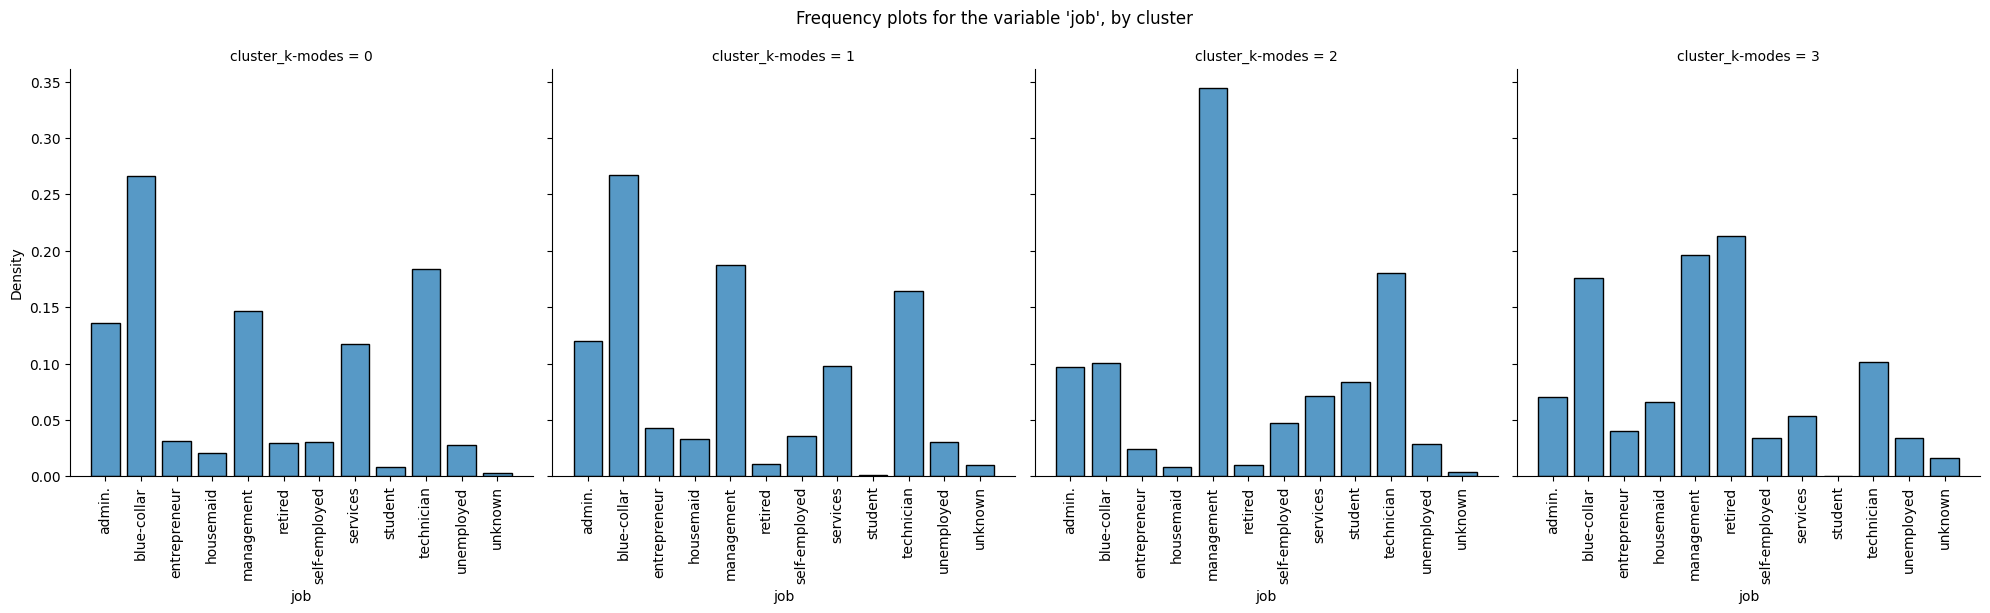

In [ ]:
g = sns.displot(data=df_bank_full,
                x='job',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)

plt.show()

## Education by Cluster

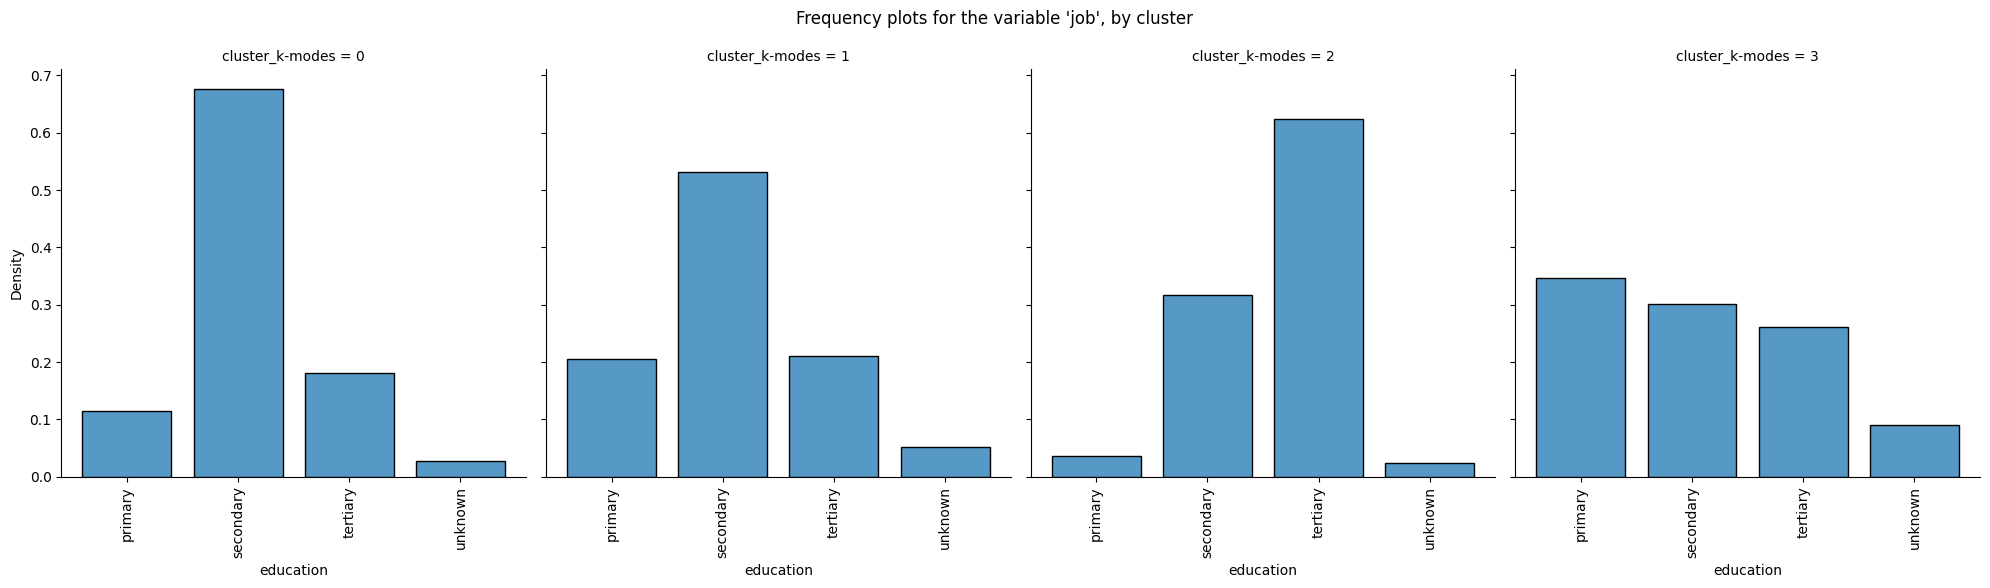

In [ ]:
g = sns.displot(data=df_bank_full,
                x='education',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'Education', by cluster", y=1.05)

plt.show()

## Marital by Cluster

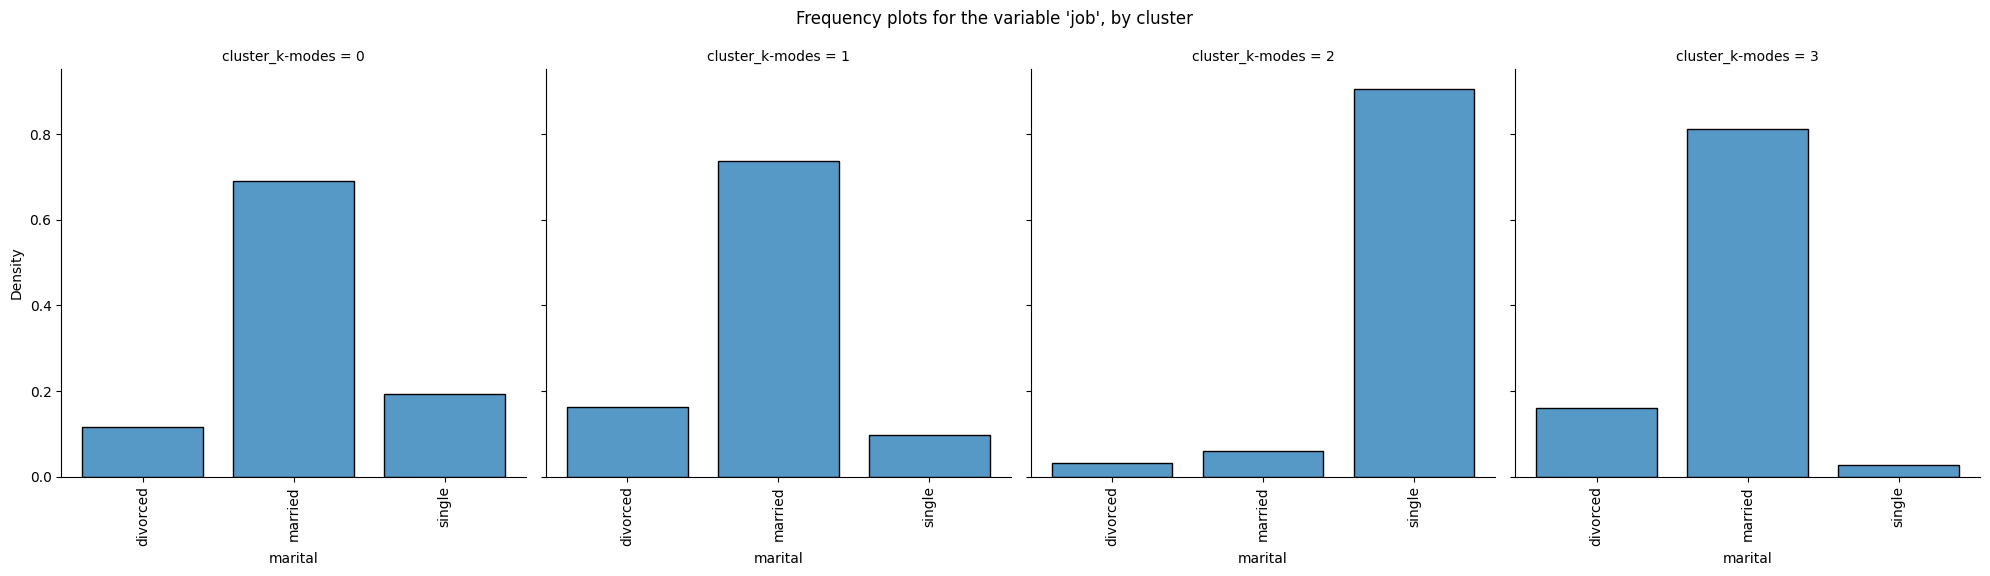

In [ ]:
g = sns.displot(data=df_bank_full,
                x='marital',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)

plt.show()

## Default by Cluster

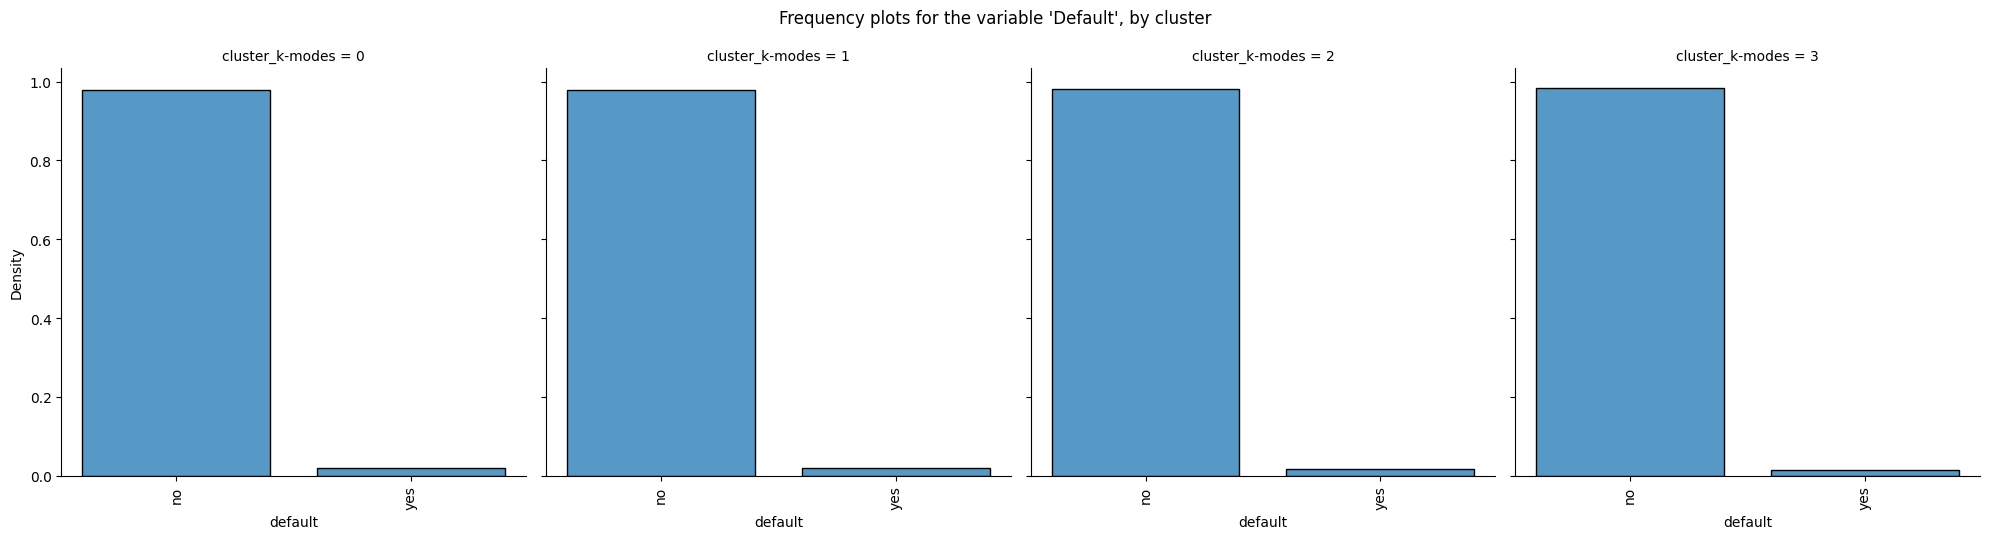

In [ ]:
g = sns.displot(data=df_bank_full,
                x='default',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'Default', by cluster", y=1.05)

plt.show()

## Housing by Cluster

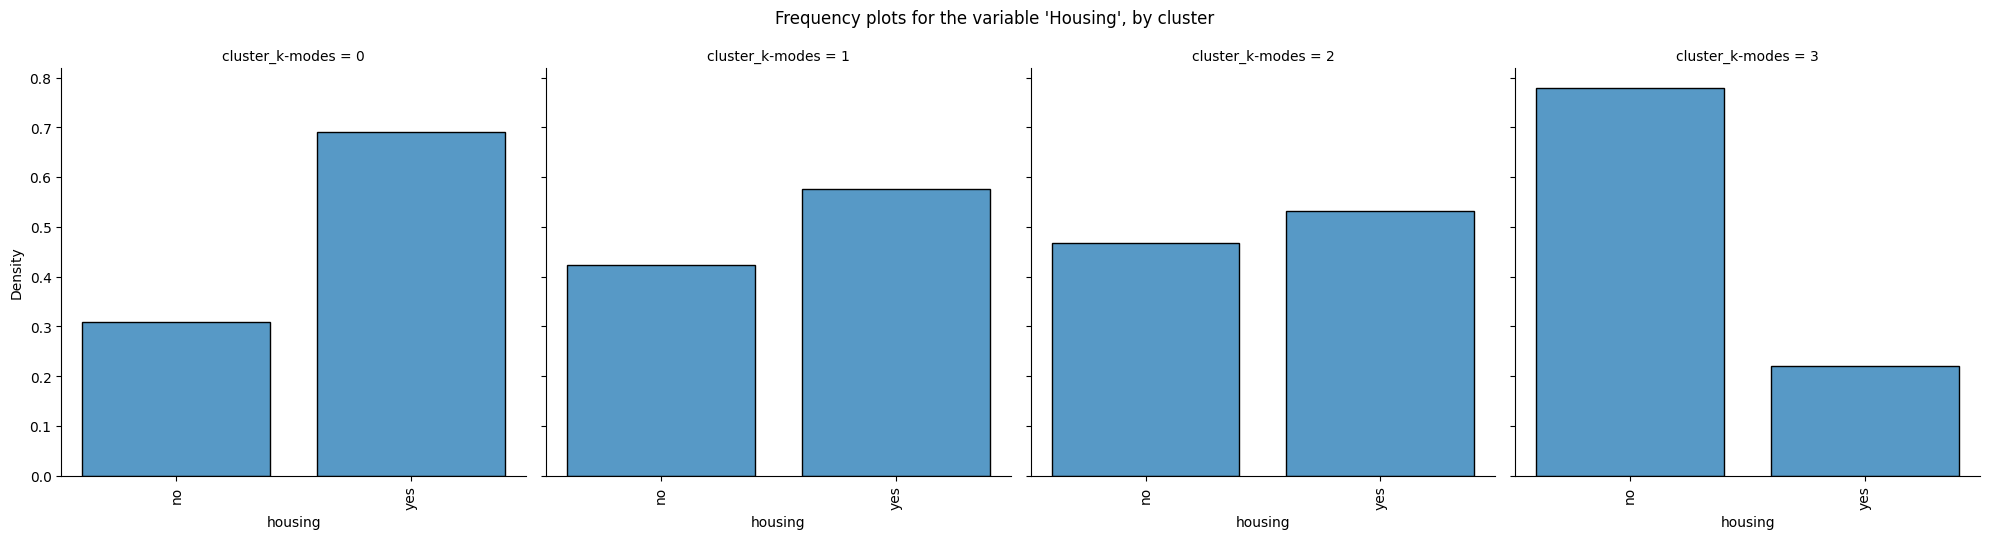

In [ ]:
g = sns.displot(data=df_bank_full,
                x='housing',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'Housing', by cluster", y=1.05)

plt.show()

## Loan by Cluster

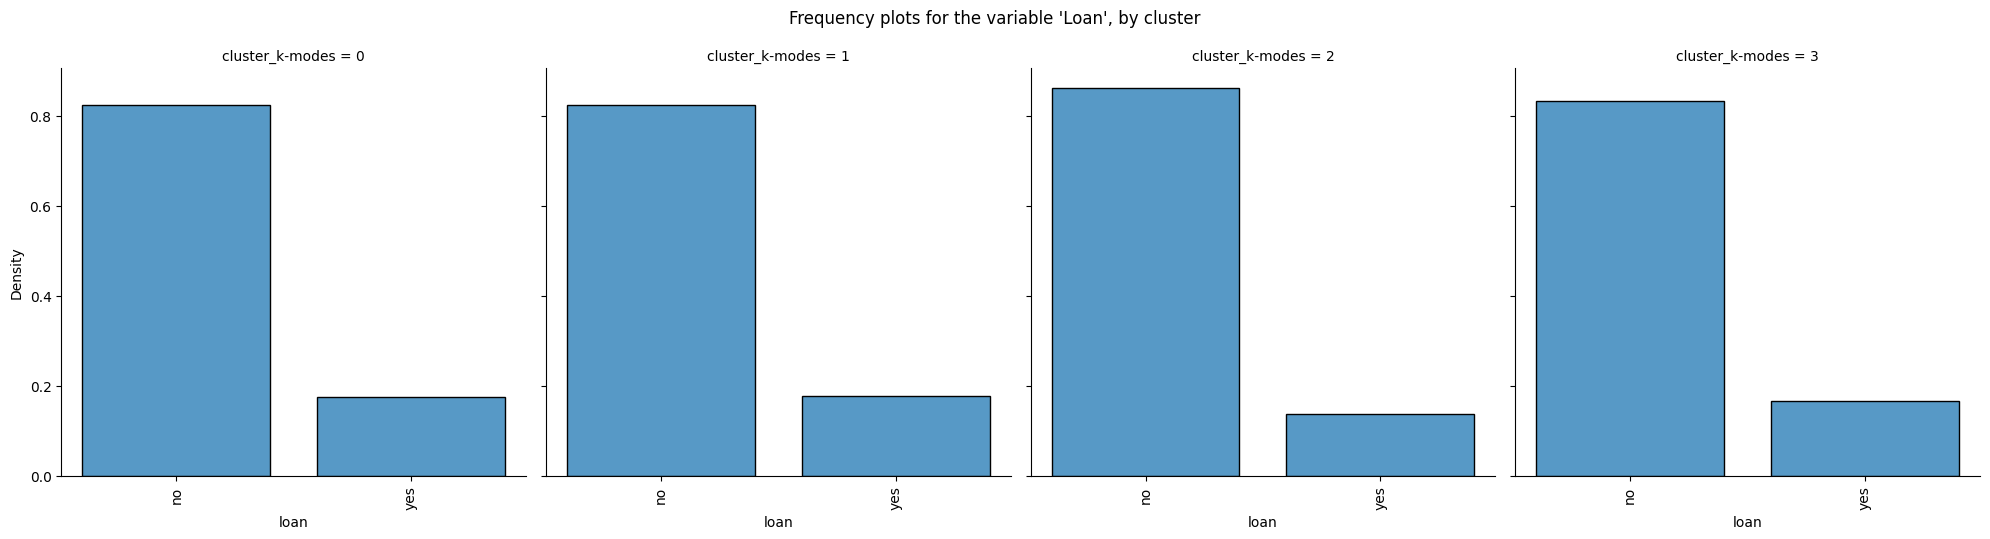

In [ ]:
g = sns.displot(data=df_bank_full,
                x='loan',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'Loan', by cluster", y=1.05)

plt.show()

# Distribution of Clusters

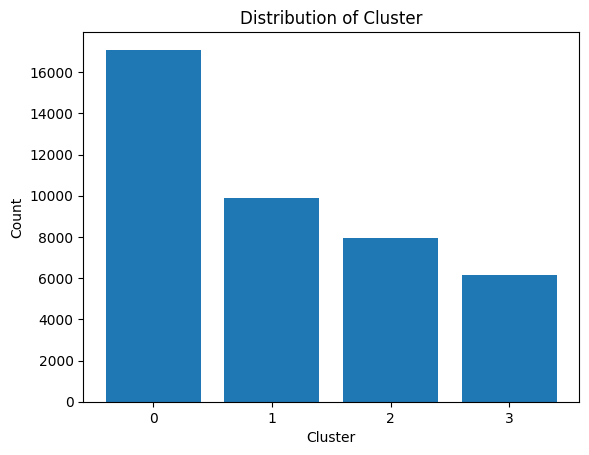

In [ ]:
# cluster_count = df_bank_full["cluster_k-modes"].value_counts().sort_index()
cluster_counts = df_bank_full.groupby('cluster_k-modes')[['cluster_k-modes']].count()
# cluster_counts
plt.bar(cluster_counts.index, cluster_counts['cluster_k-modes'])
plt.title("Distribution of Cluster")
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(cluster_means.index)
plt.show()

# Customer Segmentation Result

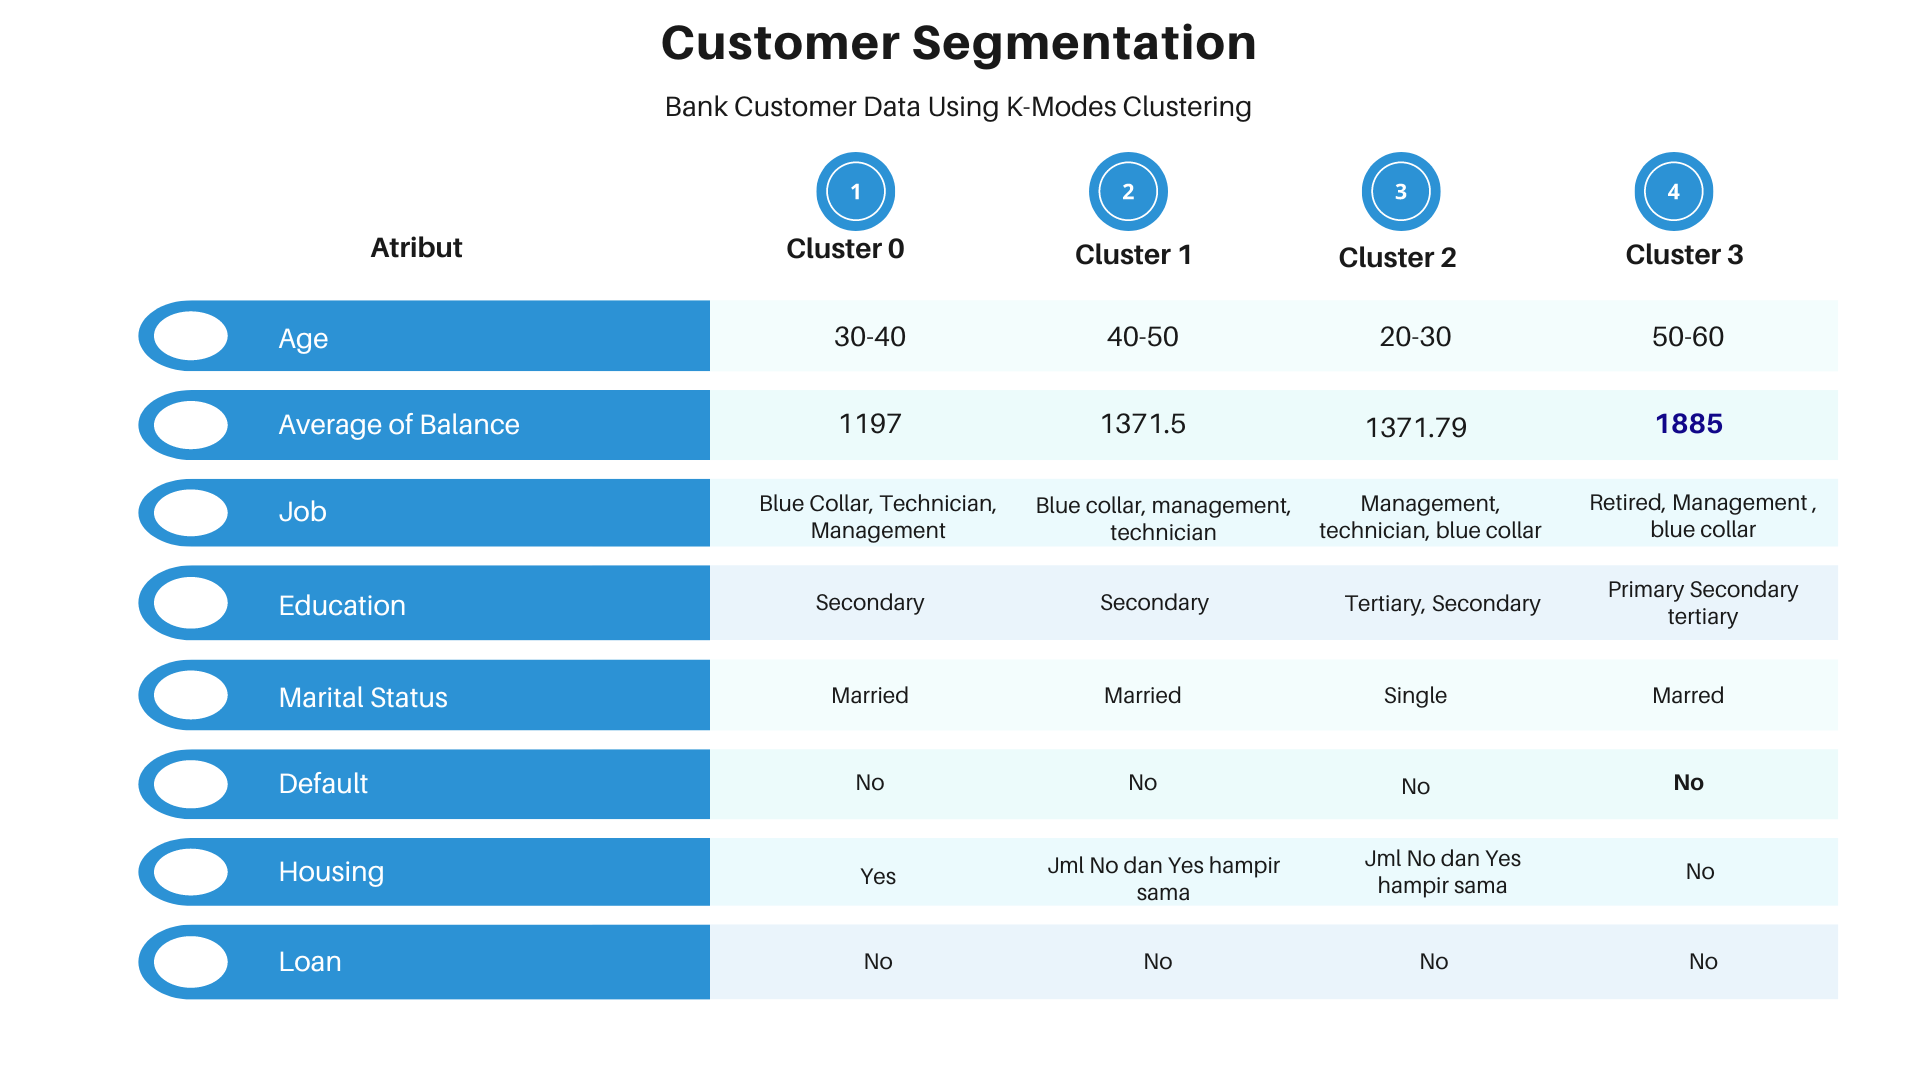



*   Cluster dengan jumlah anggota terbanyak adalah cluster 0, sedangkan nilai balance di nasabah yang tergolong cluster 0 relatif lebih rendah dibandingkan cluster lainnya. Cluster ini didominasi oleh usia 30-40 tahun dan mayoritas sudah berkeluarga
*  Cluster dengan jumlah anggota paling sedikit adalah cluster 3 padahal nilai balance cluster ini relatif lebih tinggi dibandingkan dengan cluster lainnya. Cluster ini didominasi oleh orang-orang yang pensiun dan berusia lanjut diatas 50 tahun
*   Cluster 1 didominasi oleh para pekerja usia 40-50 tahun yang mayoritas sudah menikah, nilai rata-rata balance di cluster ini cenderung pertengahan jika dibandingkan dengan cluster lainnya. Namun ternyata jika dibandingkan dengan cluster lainnya jumlah anggota cluster 1 yang meminjam uang di bank relatif lebih banyak dibandingkan dengan cluster lainnya
*   Cluster 2 didominasi oleh usia muda sekitar 20-40 tahun dan ada juga beberapa yang berusia dibawah 20 tahun. Mayoritas masih belum menikah, jumlah anggota cluster yang memiliki pinjaman juga paling rendah diantara cluster lainnya.






## Rekomendasi Bisnis/Marketing

---


*   Pelanggan terbanyak adalah pelanggan dengan cluster 0, namun sayangnya justru di cluster ini balancenya paling sedikit nominalnya. Sehingga untuk meningkatkan balance dari cluster ini dapat dilakukan beberapa rekomendasi yaitu:


1.   Program tabungan/biaya pendidikan (karena mayoritas sudah menikah sehingga pendidikan anak menjadi concern mereka).
2.   Program investasi syariah
3.    Pembayaran tagihan keperluan rumah tangga ex: listrik, air, dll
4. Program tabungan haji dan kurban


*   Pelanggan cluster 3 memiliki jumlah yang paling sedikit namun ternyata balance nya besar. Sehingga dapat dilakukan rekomendasi bisnis sebagai berikut:
1. Program haji
2. Program tabungan untuk kesehatan
3. Program pembiayaan kepemilikan rumah (karena banyak yg tidak memiliki rumah)

CATATAN:

Bank disini diasumsikan sebagai bank syariah yang benar-benar menerapkan prinsip-prinsip syariah dalam muamalah. Sehingga segala akad dan program yang dijalankan harus sesuai dengan ketentuan syariah dan didiskusikan bersama pihak-pihak yang memiliki keilmuan di bidangnya.



